<a href="https://colab.research.google.com/github/lizathulya/SkyCast/blob/main/Predictive_Weather_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Load dataset
df = pd.read_csv("/content/GlobalWeatherRepository.csv")
# Preview
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [3]:
df.info()
print(df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94121 entries, 0 to 94120
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       94121 non-null  object 
 1   location_name                 94121 non-null  object 
 2   latitude                      94121 non-null  float64
 3   longitude                     94121 non-null  float64
 4   timezone                      94121 non-null  object 
 5   last_updated_epoch            94121 non-null  int64  
 6   last_updated                  94121 non-null  object 
 7   temperature_celsius           94121 non-null  float64
 8   temperature_fahrenheit        94121 non-null  float64
 9   condition_text                94121 non-null  object 
 10  wind_mph                      94121 non-null  float64
 11  wind_kph                      94121 non-null  float64
 12  wind_degree                   94121 non-null  int64  
 13  w

In [5]:
# Handle missing values
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Ensure target column exists
if "precip_mm" in df.columns:
    # Binary classification: Rain (1) if precip > 0, else No Rain (0)
    df["Rainfall"] = (df["precip_mm"] > 0).astype(int)

    X = df.drop(["precip_mm", "Rainfall"], axis=1)
    y = df["Rainfall"]

    # Train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    raise ValueError("❌ Target column 'precip_mm' not found after preprocessing!")

# Baseline model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

baseline = LogisticRegression(max_iter=500)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))


Baseline Accuracy: 0.6613014608233732
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     12449
           1       0.50      0.00      0.00      6376

    accuracy                           0.66     18825
   macro avg       0.58      0.50      0.40     18825
weighted avg       0.61      0.66      0.53     18825



In [6]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9127224435590969
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12449
           1       0.91      0.83      0.87      6376

    accuracy                           0.91     18825
   macro avg       0.91      0.89      0.90     18825
weighted avg       0.91      0.91      0.91     18825



In [10]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

# Reduce the size of the training data for GridSearchCV to reduce memory usage
# Using a subset of 20% of the training data for grid search
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42, stratify=y_train
)

# Reduced cv to 2 to decrease memory usage
grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_subset, y_train_subset)

print("Best Parameters:", grid.best_params_)

# Train the best model on the full training data
best_rf = RandomForestClassifier(**grid.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_best))

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Tuned Random Forest Accuracy: 0.7267994687915007


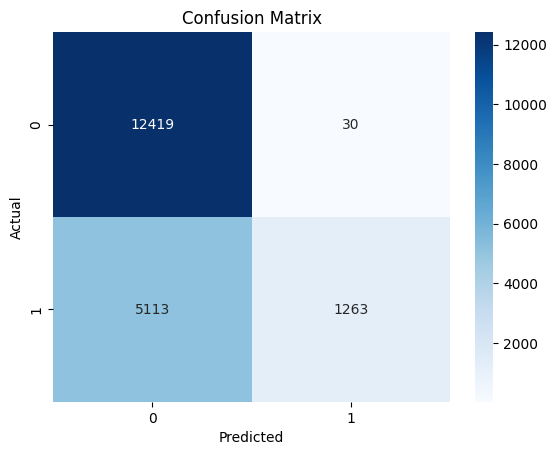

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


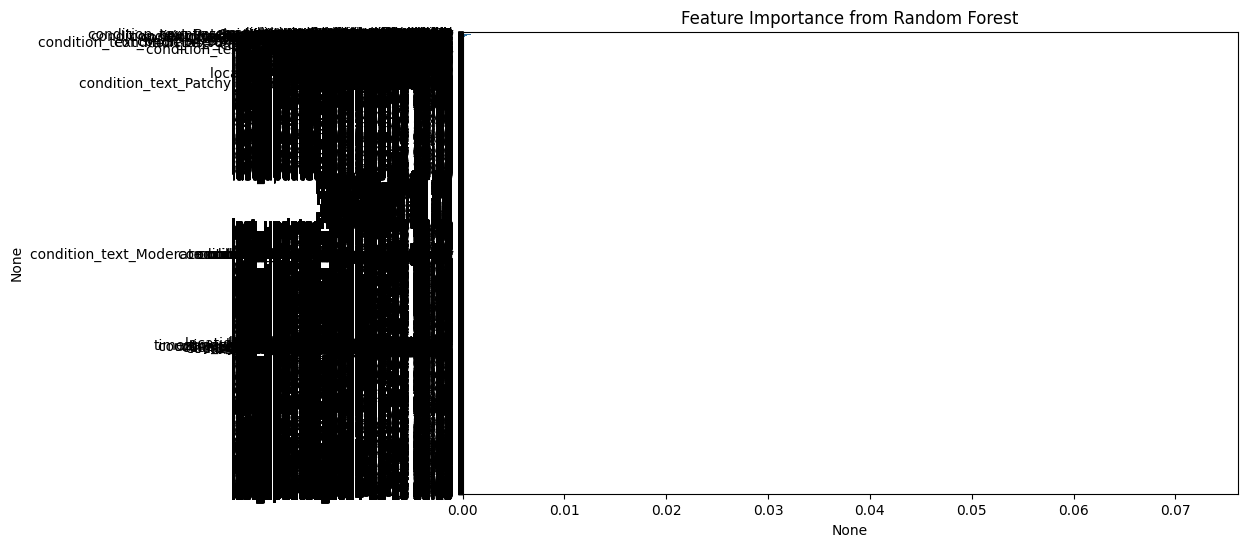

In [11]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
importances = best_rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance from Random Forest")
plt.show()